In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
from scipy.signal import find_peaks
from astropy.io import fits
from tqdm.autonotebook import tqdm
from rascal.calibrator import Calibrator

/usr/local/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In this notebook we'll examine settings for the Hough transform, also known as hyperparameters.

First let's get a spectrum. We load the fits file, do a median stack to get a 1D spectrum and then we clip the first 110 pixels as they are not usable.

Text(0, 0.5, 'y pixel')

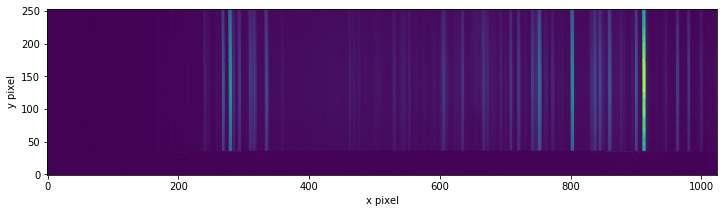

In [4]:
spectrum_image = fits.open('v_a_20190516_55_1_0_1.fits')[0].data

spectrum = np.median(spectrum_image[110:130], axis=0)[110:]
figure(1, figsize=(12,8))
imshow(spectrum_image, origin='lower')
xlabel('x pixel')
ylabel('y pixel')

and find some peaks:

In [5]:
pix_scale = 9.2
peaks, _ = find_peaks(
  spectrum, distance=3., prominence=np.percentile(spectrum, 20))

print(peaks)

[131 159 170 184 200 207 225 249 352 420 435 443 495 525 557 562 584 599
 611 620 631 642 653 663 693 722 726 734 750 767 789 803 835 853 870 889]


In [6]:
#NB The small peak on the left is at 4500, the peak on the far right is at 

Text(0, 0.5, 'Total ADU')

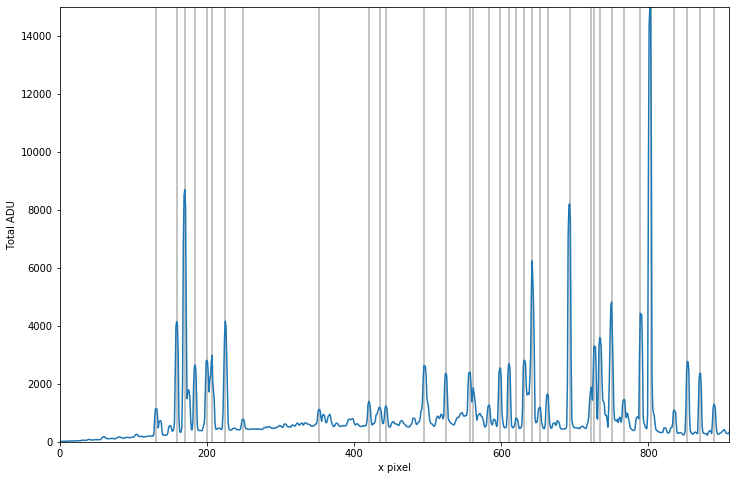

In [7]:
figure(1, figsize=(12,8))
plot(spectrum)
vlines(peaks, 0, max(spectrum), alpha=0.3)
ylim(0,15000)
xlim(0,910)
xlabel('x pixel')
ylabel('Total ADU')

This is what the arc should look like (note the first sizable peak on the left is at 4500, and the peaks to the far right are 7807, 7887, 7967, and likely 8057.26:

<img src="https://telescope.livjm.ac.uk/TelInst/Inst/SPRAT/sprat_xenon_arc.png" width=800/>

Now we instantiate a calibrator. We can see from the above plot, and recognising some key lines that our range is around 3800 to 8000A.

In [8]:
c = Calibrator(peaks, len(spectrum), min_wavelength=4000., max_wavelength=8000., plotting_library='plotly')
c.add_atlas(["Xe"])
c.set_fit_constraints(range_tolerance=500)

First, let's get some accumulators with different values of the `num_slopes` setting:

In [9]:
num_slopes = [10,50,100,500,1000,5000,10000]

accumulators = {}

for n in num_slopes:
    accumulators[n] = c._hough_points(c.pairs[:,0], c.pairs[:,1], num_slopes=n)

We can see what the accumulator looks like for various values of the slope resolution:

Text(0.5, 0, 'Gradient')

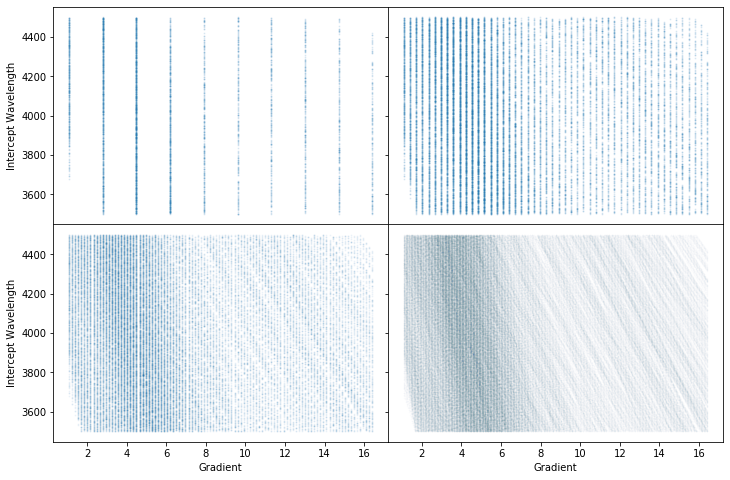

In [26]:
fig, axs = plt.subplots(2, 2, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(12,8))
(ax1, ax2), (ax3, ax4) = axs
ax1.scatter(*accumulators[10].T, s=1, alpha=0.1)
ax2.scatter(*accumulators[50].T, s=1, alpha=0.1)
ax3.scatter(*accumulators[100].T, s=1, alpha=0.05)
ax4.scatter(*accumulators[500].T, s=1, alpha=0.01)

ax1.set_ylabel('Intercept Wavelength')
ax3.set_ylabel('Intercept Wavelength')
ax3.set_xlabel('Gradient')
ax4.set_xlabel('Gradient')

In [11]:
print(c.min_slope, c.max_slope)
print(c.min_intercept, c.max_intercept)

1.0940919037199126 16.411378555798688
3500.0 4500.0


Note that we've chosen to enumerate over dispersion - the algorithm works by choosing a range of dispersion values to check, and finds the intercept values that supports them (i.e. we solve y = mx+c for c given m). We could equivalently search over a range of initial wavelengths and calculate what dispersions would support that.

In [12]:
def plot_binned_accumulator(hist, xedge, yedge, c):
    min_x = (xedge[1]-xedge[0])/2
    max_x = xedge[-1]-min_x

    min_y = (yedge[1]-yedge[0])/2
    max_y = yedge[-1]-min_y

    imshow(hist, extent=[min_x, max_x, min_y, max_y], aspect='auto')
    xlim(c.min_slope, c.max_slope)
    ylim(c.min_intercept, c.max_intercept)

In [13]:
accumulators.keys()

dict_keys([10, 50, 100, 500, 1000, 5000, 10000])

In [14]:
def plot_accumulator(c, a, nbins=50):
    hist, xedge, yedge = np.histogram2d(a[:, 1],
                                    a[:, 0],
                                    bins=(nbins, nbins),
                                    range=((c.min_intercept, c.max_intercept),
                                          (c.min_slope, c.max_slope)))
    
    # left, right, bottom, top
    imshow(hist, extent=[c.min_slope, c.max_slope, c.min_intercept, c.max_intercept], aspect='auto', origin='lower')

Text(0.5, 0.98, 'Accumulator of size 50')

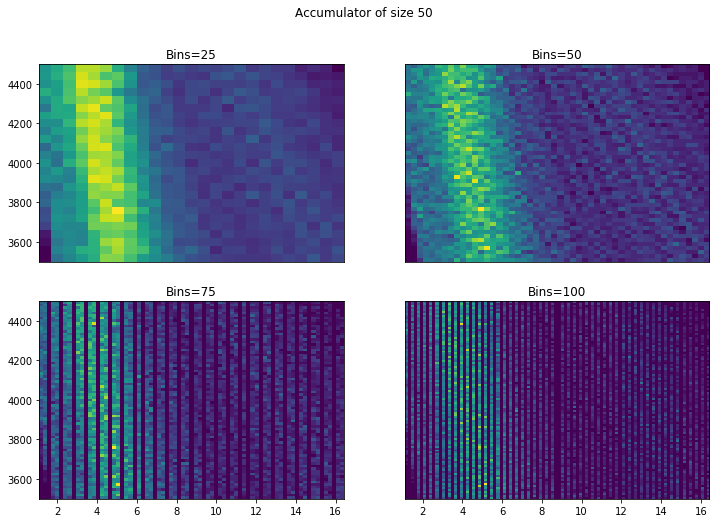

In [15]:
figure(1, figsize=(12,8))
subplot(221)
plot_accumulator(c, accumulators[50], nbins=25)
plt.xticks([])
title("Bins=25")
subplot(222)
plot_accumulator(c, accumulators[50], nbins=50)
plt.xticks([])
plt.yticks([])
title("Bins=50")
subplot(223)
plot_accumulator(c, accumulators[50], nbins=75)
title("Bins=75")
subplot(224)
plot_accumulator(c, accumulators[50], nbins=100)
plt.yticks([])
title("Bins=100")
suptitle("Accumulator of size 50")

Text(0.5, 0.98, 'Accumulator of size 100')

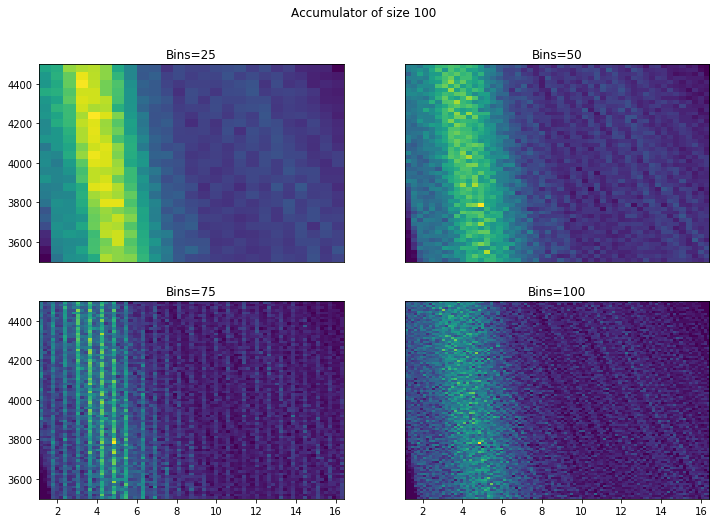

In [16]:
figure(1, figsize=(12,8))
subplot(221)
plot_accumulator(c, accumulators[100], nbins=25)
plt.xticks([])
title("Bins=25")
subplot(222)
plot_accumulator(c, accumulators[100], nbins=50)
plt.xticks([])
plt.yticks([])
title("Bins=50")
subplot(223)
plot_accumulator(c, accumulators[100], nbins=75)
title("Bins=75")
subplot(224)
plot_accumulator(c, accumulators[100], nbins=100)
plt.yticks([])
title("Bins=100")
suptitle("Accumulator of size 100")

Text(0.5, 0.98, 'Accumulator of size 1k')

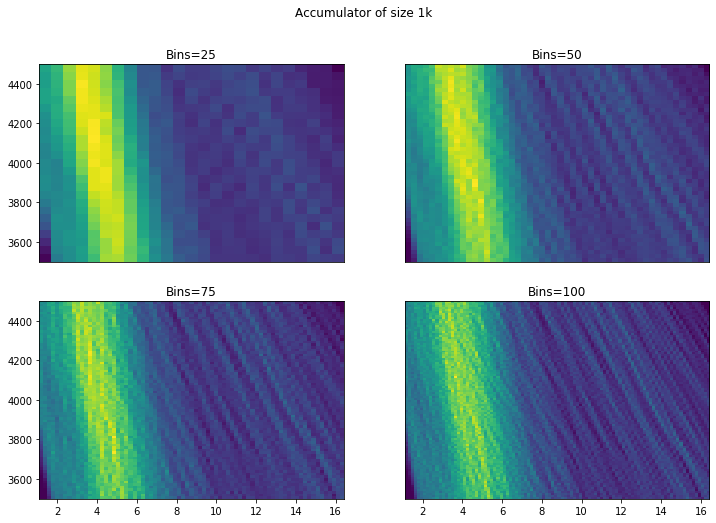

In [17]:
figure(1, figsize=(12,8))
subplot(221)
plot_accumulator(c, accumulators[1000], nbins=25)
plt.xticks([])
title("Bins=25")
subplot(222)
plot_accumulator(c, accumulators[1000], nbins=50)
plt.xticks([])
plt.yticks([])
title("Bins=50")
subplot(223)
plot_accumulator(c, accumulators[1000], nbins=75)
title("Bins=75")
subplot(224)
plot_accumulator(c, accumulators[1000], nbins=100)
plt.yticks([])
title("Bins=100")
suptitle("Accumulator of size 1k")

Text(0.5, 0.98, 'Accumulator of size 10k')

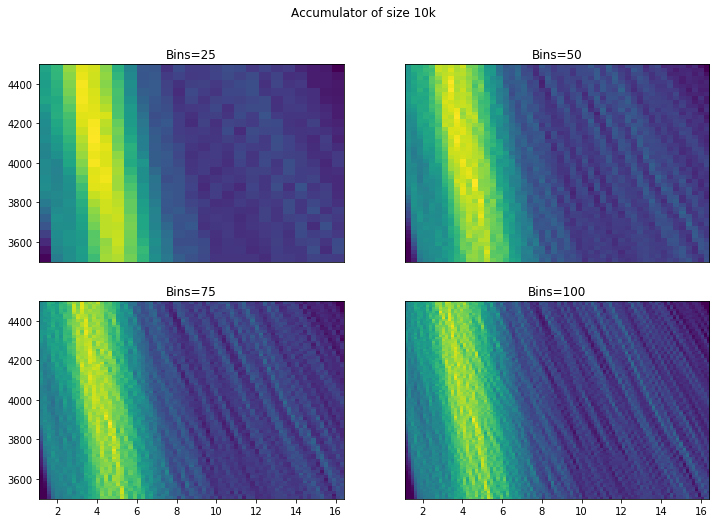

In [18]:
figure(1, figsize=(12,8))
subplot(221)
plot_accumulator(c, accumulators[10000], nbins=25)
plt.xticks([])
title("Bins=25")
subplot(222)
plot_accumulator(c, accumulators[10000], nbins=50)
plt.xticks([])
plt.yticks([])
title("Bins=50")
subplot(223)
plot_accumulator(c, accumulators[10000], nbins=75)
title("Bins=75")
subplot(224)
plot_accumulator(c, accumulators[10000], nbins=100)
plt.yticks([])
title("Bins=100")
suptitle("Accumulator of size 10k")

Two things stand out here. Firstly, it is important to have a high resolution Hough transform so that we don't miss possible fits. Secondly, more bins are good - we can see from 50+ that we start to identify a possible solution (the small hotspot/peak). However while there does seem to be an improvement going to around 75 bins, going to 100 isn't visually very different. Similarly there doesn't appear to be a huge advantage in choosing a very small bin 

We can do a small grid search over the two variables: slope resolution (defined by the number of slope bins and wavelength range) and the histogram bin resolution.

Text(0, 0.5, 'Max bin / mean bin value')

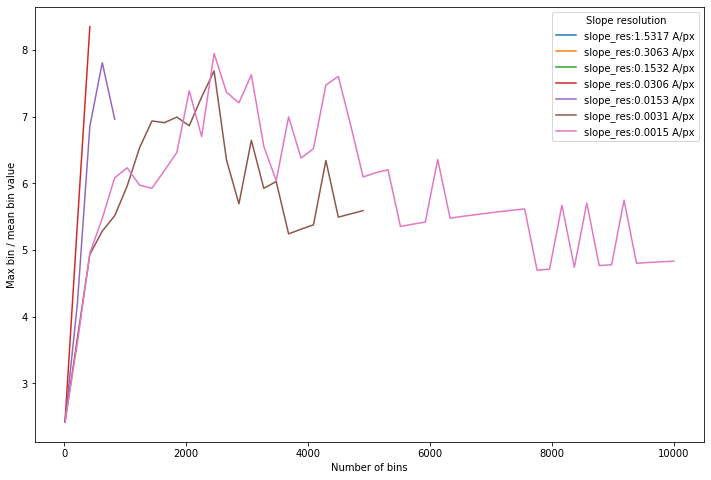

In [19]:
figure(10, figsize=(12,8))

slope_range = c.max_slope-c.min_slope

for ns in tqdm(num_slopes):
    x = []
    y = []
    for nb in np.linspace(10,10000):
        
        if nb > ns:
            continue
        
        a = accumulators[ns]
        hist, xedge, yedge = np.histogram2d(a[:, 0],
                            a[:, 1],
                            bins=(int(nb), int(nb)),
                            range=((c.min_slope, c.max_slope),
                                   (c.min_intercept, c.max_intercept)))
        
        x.append(nb)
        y.append(hist.max()/hist[hist > 0].mean())
    
    plt.plot(x, y, label="slope_res:{} A/px".format(round(slope_range/ns, 4), ns))
legend(title="Slope resolution")
plt.xlabel("Number of bins")
plt.ylabel("Max bin / mean bin value")

These curves are essentially showing how "good" the best line fit is. We don't want a histogram where there are lots of potential choices. It looks empirically that the number of bins should be around half the number of slopes to maximise contrast. A sensible default of 1k slopes with 500 bins is appropriate (at least for this dispersion and range).

Sanity check, what lines do these settings yield?

In [20]:
hist, lines = c._get_top_lines(accumulator=accumulators[1000], top_n=5, xbins=500, ybins=500)

We want to get a set of points with a high precision - that is, we want as many true positives as possible, at the risk that we've included a few false positives too. So it's important at this stage, that the acceptance threshold is quite high - as much as 50A or even 100A.

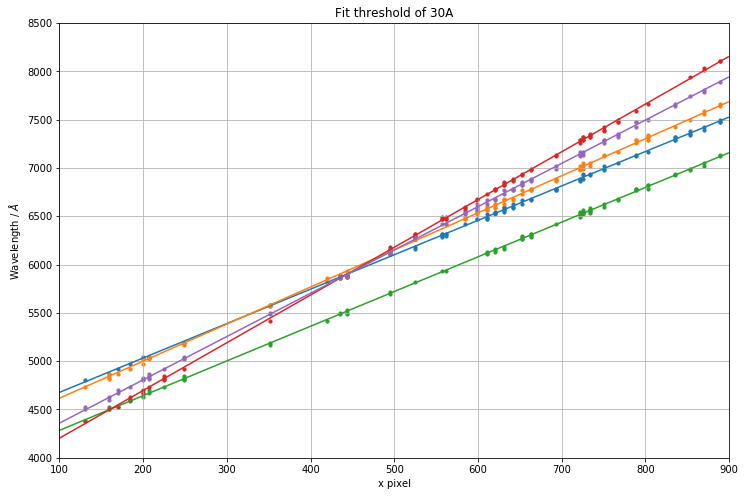

In [21]:
for line in lines[::-1]:
    slope, intercept = line
    peaks, wavelengths = c._get_candidate_points_linear(slope, intercept, thresh=30)
    x = np.arange(100,900)
    y = x*slope + intercept
    figure(1, figsize=(12,8))
    scatter(peaks, wavelengths, s=10)
    plot(x, y)
    title("Fit threshold of 30A")
    xlabel('x pixel')
    ylabel(r'Wavelength / ${\AA}$')
    grid()
    xlim(100,900)
    ylim(4000,8500)

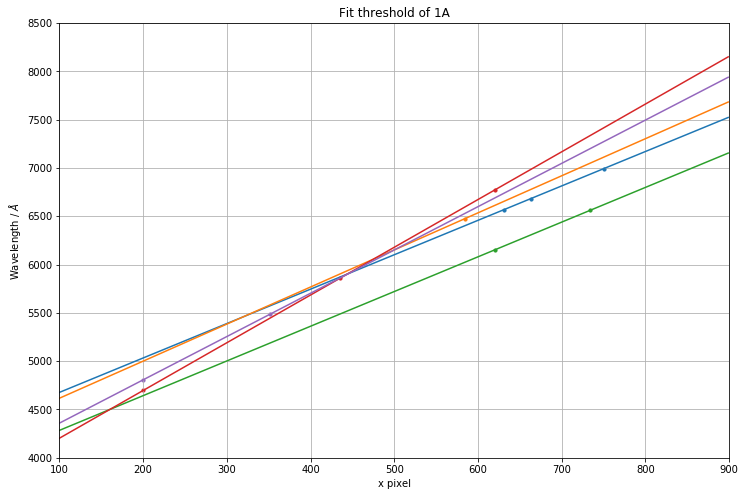

In [22]:
for line in lines[::-1]:
    slope, intercept = line
    peaks, wavelengths = c._get_candidate_points_linear(slope, intercept, thresh=1)
    x = np.arange(100,900)
    y = x*slope + intercept
    figure(1, figsize=(12,8))
    scatter(peaks, wavelengths, s=10)
    plot(x, y)
    title("Fit threshold of 1A")
    xlabel('x pixel')
    ylabel(r'Wavelength / ${\AA}$')
    grid()
    xlim(100,900)
    ylim(4000,8500)

In [23]:
peaks, wavelengths

(array([200., 352.]), array([4807.02, 5488.56]))

These look ok, certainly in a feasible range.